In [3]:
!pip install rdkit
!pip install mordred
!pip install pubchempy
!pip install padelpy
!pip install mp-api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 KB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.9 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176723 sha256=3a441376e24836c19aa9a156cae1395426590acec4d53a936050ed8427daddde
  Stored in directory: /root/.cache/pip/wheels/05/95/d1/9e913738f0e8362b3676917b953a60afd76d2b0b99ff8a71ec
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.0
    Uninstalling networkx-3.0:
      Successfully uninstalled networkx-3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [4]:
import re

import pandas as pd
import numpy as np
import pubchempy as pcp
from mordred import Calculator, descriptors
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import rdMolDescriptors
from urllib.request import urlopen
from urllib.parse import quote
from padelpy import from_smiles
# from mp_api.client import MPRester
from pymatgen.ext.matproj import MPRester

FileNotFoundError: ignored

For homework, we chose 8 datasets

In [4]:
df = pd.read_csv('/content/8.csv')

## Data Preparation

For now, we remove all lines where there is nothing in `Name`

In [5]:
df = df[~df['Name'].isna()]
df = df.drop_duplicates().reset_index(drop=True)
df

,DOI,Date,Journal,Title,Name,measurement_error,measurement_wavelength,measurement_method,normalised_name,raw_value,specifier
0,10.1039/C6RA04584G_© The Royal Society of Chem...,NaN,NaN,NaN,silicate,0.04,NaN,snowball,NaN,1.21 – 1.13,refractive index
1,10.1016/j.mssp.2013.07.031,8/24/2013,Materials Science in Semiconductor Processing,PREPARATIONCHARACTERIZATIONAPPLICATIONRFSPUTTE...,BSG,0.00,NaN,el_mylogic,"[['B', 1.0], ['SG', 1.0]]",1.41,Refractive index (n)
2,10.1039/C7NR03175K,NaN,NaN,NaN,silica,0.00,NaN,snowball,O=[Si]=O,1.48,refraction index
3,10.1016/j.saa.2012.10.018,10/24/2012,Spectrochimica Acta Part A: Molecular and Biom...,SOLVENTEFFECTABSORPTIONFLUORESCENCESPECTRA7ACE...,DMF,0.00,NaN,el_mylogic,CN(C)C=O,1.4305,n
4,10.1016/j.conbuildmat.2018.05.016Construction ...,NaN,NaN,NaN,silica,0.00,NaN,snowball,O=[Si]=O,1.46,refractive index
...,...,...,...,...,...,...,...,...,...,...,...
4975,10.1016/j.poly.2011.03.003,3/17/2011,Polyhedron,PHOTOPHYSICALPROPERTIESPHOTOCYTOTOXICITYNOVELP...,2-Propanol,0.00,NaN,el_mylogic,NaN,1.377,Refractive index (20 °C)
4976,10.1016/j.optlastec.2019.01.028,2/6/2019,Optics & Laser Technology,SPECTROCHEMICALSTUDYMOLDAVITESRIESIMPACTSTRUCT...,MgO,0.00,NaN,el_cde_tables,"[['Mg', 1.0], ['O', 1.0]]",1.75,n
4977,10.1016/j.ssc.2010.03.031,4/8/2010,Solid State Communications,BROADBAND15MEMISSIONHIGHERBIUMDOPEDBI2O3B2O3GA...,Silicate,0.00,NaN,el_cde_tables,NaN,1.585,Refractive index
4978,10.1016/j.molliq.2017.05.096,5/23/2017,Journal of Molecular Liquids,SOLVATOCHROMICANALYSISDFTCOMPUTATIONALSTUDYAZO...,Diethylether,0.00,NaN,el_mylogic,CCOCC,1.3526,n


Our target value is `raw_value`. We should clean it. 

In [6]:
# Replace unnecessary characters with commas to split the string
df['raw_value'] = df['raw_value'].str.replace('–', ',') 
df['raw_value'] = df['raw_value'].str.replace('~', '') 
df['raw_value'] = df['raw_value'].str.replace(' , ', ',')
df['raw_value'] = df['raw_value'].str.replace(' - ', ',')
df['raw_value'] = df['raw_value'].str.replace(' to ', ',')
df['raw_value'] = df['raw_value'].str.replace('/', ',')

In [7]:
# Remove errors
def remove_error(x):
  if '(' in x:
    a = re.sub(r'\([^)]*\)', '', x)
    return a.strip()
  if '±' in x:
    a, b = x.split('±')
    return a.strip()
  else:
    return x


df['raw_value'] = df['raw_value'].apply(remove_error)

In [9]:
df_raw_value = df['raw_value'].str.split(',', expand=True).rename(columns={0:'r_v2', 1:'r_v3'})

In [12]:
pattern = re.compile(r'\d+\.?\d*')
df_raw_value['r_v2'] = df_raw_value['r_v2'].apply(lambda x: float(pattern.search(str(x)).group()) if pattern.search(str(x)) else None)
df_raw_value['r_v3'] = df_raw_value['r_v3'].apply(lambda x: float(pattern.search(str(x)).group()) if pattern.search(str(x)) else None)

In [15]:
df['raw_value_clean'] = df_raw_value[['r_v2', 'r_v3']].mean(skipna=True, axis=1)
df[['raw_value', 'raw_value_clean']]

,raw_value,raw_value_clean
0,"1.21 , 1.13",1.1700
1,1.41,1.4100
2,1.48,1.4800
3,1.4305,1.4305
4,1.46,1.4600
...,...,...
4975,1.377,1.3770
4976,1.75,1.7500
4977,1.585,1.5850
4978,1.3526,1.3526


Display values less than 1 and replace them with NaN and delete empty values withe whole row

In [19]:
less_than_one = df.loc[df['raw_value_clean'] < 1, 'raw_value_clean']
df.loc[df['raw_value_clean'] < 1, 'raw_value_clean'] = pd.np.nan

<ipython-input-19-453398376a27>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.loc[df['raw_value_clean'] < 1, 'raw_value_clean'] = pd.np.nan


But in box plot we can see that there is a lot of outliers. Remove it by quantiles.

<Axes: >

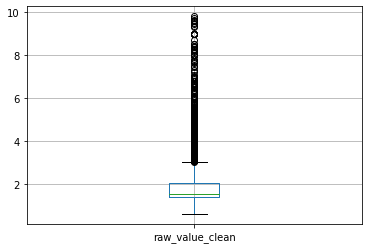

In [18]:
df.boxplot(column='raw_value_clean')

In [20]:
Q1 = df['raw_value_clean'].quantile(0.25)
Q3 = df['raw_value_clean'].quantile(0.75)
IQR = Q3 - Q1
df.loc[(df['raw_value_clean'] < Q1 - 1.5 * IQR) | (df['raw_value_clean'] > Q3 + 1.5 * IQR), 'raw_value_clean'] = pd.np.nan
df = df.dropna(subset=['raw_value_clean'])

<ipython-input-20-ff24a3fe6315>:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  df.loc[(df['raw_value_clean'] < Q1 - 1.5 * IQR) | (df['raw_value_clean'] > Q3 + 1.5 * IQR), 'raw_value_clean'] = pd.np.nan


Remove useless columns: `measurement_wavelength` is almost None, and Journal information

In [38]:
df = df.drop(['DOI',	'Date', 'Journal', 'Title', 'measurement_wavelength', 'specifier'], axis=1)

With the help of PubChem, we will add smiles that are not in the table.

In [40]:
def smiles(x):
  try:
    return pcp.get_properties('CanonicalSMILES', x, 'name')[0]['CanonicalSMILES']
  except:
    return np.nan

df.loc[df['normalised_name'].isna(), 'normalised_name'] = df.loc[df['normalised_name'].isna(),'Name'].apply(smiles)

It takes a long time to fill, save the dataset for further work.

In [41]:
df.to_csv('/content/df_1.csv', index=False)

In [ ]:
df = pd.read_csv('/content/df_1.csv')

Substances can often be repeated, take unique

In [42]:
df_names = df.loc[df['Name'].drop_duplicates().index, ['Name', 'normalised_name']]

We have several problems:

* some smiles are missing
* some smiles are incorrect and libraries won't parse them
* and some smiles are wrong, but the libraries count them

With the first one, we can’t do anything yet, we’ll work with them further.

With the second ones, you can try to run the translation of the substance into smiles in pubchem and see if they are the same if the substance is found.

In [44]:
df_names['smiles'] = np.nan
df_names.loc[~df_names['normalised_name'].isna(), 'smiles'] = df_names.loc[~df_names['normalised_name'].isna(),'Name'].apply(smiles)

There are obviously a lot of discrepancies, some are rather a variant of the smiley difference, some are clearly a mistake, we will replace them

In [45]:
d = df_names[df_names['smiles'] != df_names['normalised_name']]
d[~d['smiles'].isna()]

,Name,normalised_name,smiles
1,BSG,"[['B', 1.0], ['SG', 1.0]]",[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O
5,ErF3,"[['Er', 1.0], ['F', 3.0]]",F[Er](F)F
23,PVP,"[['P', 2.0], ['V', 1.0]]",C=CN1CCCC1=O
25,CO2,O=C=O,C(=O)=O
29,TOL,COc1ccc2c(cccc2c1C(F)(F)F)C(=S)N(C)CC(O)=O,CN(CC(=O)O)C(=S)C1=CC=CC2=C1C=CC(=C2C(F)(F)F)OC
...,...,...,...
4674,Heptylbenzene,CCCCCCCc1ccccc1,CCCCCCCC1=CC=CC=C1
4803,diiodomethane,ICI,C(I)I
4868,IrO2,"[['Ir', 1.0], ['O', 2.0]]",O=[Ir]=O
4959,tert-Butylmethylether,COC(C)(C)C,CC(C)(C)OC


In [46]:
df_names.loc[d[~d['smiles'].isna()].index, 'normalised_name'] = df_names.loc[d[~d['smiles'].isna()].index, 'smiles']
df_names = df_names.drop('smiles', axis=1)

With the third option, you can run rdkit so that it tries to build an instance of the smiles molecule

In [47]:
def check_smiles(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol:
      return True
    else:
      return False

df_names['check_smiles'] = np.nan
df_names.loc[~df_names['normalised_name'].isna(), 'check_smiles'] = df_names.loc[~df_names['normalised_name'].isna(),'normalised_name'].apply(check_smiles)

[18:12:11] SMILES Parse Error: syntax error while parsing: [['Al',
[18:12:11] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[18:12:11] SMILES Parse Error: syntax error while parsing: [['IL',
[18:12:11] SMILES Parse Error: Failed parsing SMILES '[['IL',' for input: '[['IL','
[18:12:11] SMILES Parse Error: syntax error while parsing: [['Al',
[18:12:11] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[18:12:11] SMILES Parse Error: syntax error while parsing: [['Mg',
[18:12:11] SMILES Parse Error: Failed parsing SMILES '[['Mg',' for input: '[['Mg','
[18:12:11] SMILES Parse Error: syntax error while parsing: [['B',
[18:12:11] SMILES Parse Error: Failed parsing SMILES '[['B',' for input: '[['B','
[18:12:11] SMILES Parse Error: syntax error while parsing: [['Eu',
[18:12:11] SMILES Parse Error: Failed parsing SMILES '[['Eu',' for input: '[['Eu','
[18:12:11] SMILES Parse Error: syntax error while parsing: [['Ge',
[18:12:11] SMILES Parse Error:

Some can be filled in by searching from `cactus.nci.nih.gov/`

In [48]:
def CIRconvert(x):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(x) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        print(x, ans)
        return ans
    except:
        return np.nan

df_names.loc[df_names['normalised_name'].isna(), 'normalised_name'] = df_names.loc[df_names['normalised_name'].isna(),'Name'].apply(CIRconvert)

silicate [O-][Si]([O-])([O-])[O-]
CoO CC(C)CO[P](O)(=O)O[P](O)(=O)OC[C@H]1O[C@H]([C@H](O)[C@@H]1O[P](O)(O)=O)n2cnc3c(N)ncnc23
TiO2 O=[Ti]=O
dimethyladipate COC(=O)CCCCC(=O)OC
Cysteamine NCCS
1-Iodonaphthalene sulfur S.Ic1cccc2ccccc12
flavonoid Oc1ccc(cc1)C2=CC(=O)c3c(O)c(O)c(O)cc3O2
SnS2nSnS2 SN[S]1NSNS1
Thiophene s1cccc1
tetralin C1CCc2ccccc2C1
Styrene C=Cc1ccccc1
Octamethyl trisiloxane C[Si](C)(C)O[Si](C)(C)O[Si](C)(C)C
PAAM OC(=O)Cc1ccc(cc1)N(CCCl)CCCl
germaniumsulphide S=[GeH2]
trans-5-Decene CCCC\C=C\CCCC
Dichloromethane ClCCl
alcohols CCO
GaN COC(=O)[C@@H](NC(=O)[C@@H](NC(=O)[C@H](C)N1CCC(=C[C@H](C1)Cc2ccccc2)[C@H](C)NC(=O)[C@H](C)N)C(C)C)C(C)C
n-Octane CCCCCCCC
KRI N[C@@H](CCSC[C@@H](O)[C@@H](O)C(=O)CO)C(O)=O
polypropylene CC=C
WO3 [OH2-].[OH2-].[OH2-].[OH2-].[W+4]
1-Bromonaphthalene Brc1cccc2ccccc12
Olivine [Mg].[Mg].[Mg].[Fe].O[Si](O)(O)O.O[Si](O)(O)O
Barium [BaH2]
SiC C=[SiH2]
carbon C
methyl ether COC
SrO O=[Sr]
CsI [I-].[Cs+]
ADP Nc1ncnc2n(cnc12)C3OC(CO[P](O)(=O)O[P](O)(O)=

It also replaced some incorrectly, we will fix it manually

In [49]:
df_names.loc[df_names[df_names["Name"] == 'germanium'].index, 'normalised_name'] = '[Ge]' 
df_names.loc[df_names[df_names["Name"] == 'GaN'].index, 'normalised_name'] = 'N#[Ga]'
df_names.loc[df_names[df_names["Name"] == 'Barium'].index, 'normalised_name'] = '[Ba]' 
df_names.loc[df_names[df_names["Name"] == 'WO3'].index, 'normalised_name'] = 'O=[W](=O)=O'
df_names.loc[df_names[df_names["Name"] == 'CoO'].index, 'normalised_name'] = 'O=[Co] '
df_names.loc[df_names[df_names["Name"] == 'SnS2nSnS2'].index, 'normalised_name'] = 'S=[Sn]'
df_names.loc[df_names[df_names["Name"] == 'SiC'].index, 'normalised_name'] = '[C-]#[Si+]'
df_names.loc[df_names[df_names["Name"] == 'ethers'].index, 'normalised_name'] = 'not found'
df_names.loc[df_names[df_names["Name"] == 'TiC'].index, 'normalised_name'] = '[C-]#[Ti+]'
df_names.loc[df_names[df_names["Name"] == 'Tb(C)'].index, 'normalised_name'] = '[Tb]'
df_names.loc[df_names[df_names["Name"] == 'NaC'].index, 'normalised_name'] = '[C-]#[Na+]' 
df_names.loc[df_names[df_names["Name"] == 'Selenium'].index, 'normalised_name'] = '[Se]' 
df_names.loc[df_names[df_names["Name"] == 'CdO'].index, 'normalised_name'] = 'O=[Cd]'
df_names.loc[df_names[df_names["Name"] == 'KI'].index, 'normalised_name'] = '[K+].[I-]'
df_names.loc[df_names[df_names["Name"] == 'Cu(II)'].index, 'normalised_name'] = '[Cu]' 
df_names.loc[df_names[df_names["Name"] == 'o-HP'].index, 'normalised_name'] = 'not found'

In [50]:
df_names.to_csv('df_names.csv', index=False)

Returning to the first problem, when we simply do not have smiles in various libraries. We use a parser and find the smiles in the puchem search page, save them and add them here.

In [51]:
pubchem_smiles = pd.read_csv('/content/pubchem_smiles.csv').rename(columns={'0': 'smiles'})

In [52]:
pubchem_smiles

,Name,smiles
0,PbO-SiO2,NaN
1,PVAc,NaN
2,MoS2,S=[Mo]=S
3,CdTe,[Cd]=[Te]
4,N2 PDA,NaN
...,...,...
1036,Zn2S28Se70,NaN
1037,MgO,O=[Mg]
1038,K2O,[O-2].[K+].[K+]
1039,FeO,O=[Fe]


In [53]:
d = pd.merge(df_names, pubchem_smiles, how = 'left', on='Name')
df_names = df_names.reset_index(drop=True)
df_names.loc[d[~d['smiles'].isna()].index, 'normalised_name'] = d[~d['smiles'].isna()]['smiles'].values
df_names

,Name,normalised_name,check_smiles
0,silicate,[O-][Si]([O-])([O-])[O-],NaN
1,BSG,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O,True
2,silica,O=[Si]=O,True
3,DMF,CN(C)C=O,True
4,ErF3,F[Er](F)F,True
...,...,...,...
1751,Triticonazole,CC1(C)CC\C(=C/c2ccc(Cl)cc2)C1(O)Cn3cncn3,NaN
1752,B2O3–TeO2,NaN,NaN
1753,tert-Butylmethylether,CC(C)(C)OC,True
1754,hydroxyl,[OH-],True


After all the edits, we are left with names that are either not really present in the selected libraries or search engines, or are not displayed correctly. It is better to correct the names of the substances first.
Potentially in the future it is possible to correct the following options:
* a mixture of metals `ZnAlBiBTb` or `Ge17As18S26Se39` to collect on separate metal smileys
* compound `Na2O–P2O5` also connect smileys in parts
* remove the trailing ' -' and other characters and run the parser again, for example

In [54]:
df_names[(df_names['check_smiles'].isna()) | (df_names['check_smiles'] is False)][150:180]

,Name,normalised_name,check_smiles
711,n-Hexadecane,CCCCCCCCCCCCCCCC,NaN
712,CeF3,F[Ce](F)F,NaN
714,Na2O·B2O3·2SiO2,NaN,NaN
718,phosphate,[O-][P]([O-])([O-])=O,NaN
720,tBA,CCCC[N+](CCCC)(CCCC)CCCC,NaN
722,AgGaSe2,[Ga+3].[Se-2].[Se-2].[Ag+],NaN
724,DEA,OCCNCCO,NaN
725,V2BC,NaN,NaN
726,Ca2SiO4,NaN,NaN
731,LiF–Sb2O3,NaN,NaN


Further verification of the dataset is highly dependent on the task that we face within the framework of the projects. We did the most basic:

* removed duplicates
* removed lines with empty names of substances
* as far as possible within the set time put smiles in order

We still have such columns as `measurement_error`, `measurement_wavelength`, `measurement_method`, `raw_value` and `specifier`.
It looks like the refractive index was measured here, by certain methods with the indicated error, if possible. Since the task of working with this indicator is not clear, outside the tasks you can look at the spread of `raw_value` and look at outliers and delete them as invalid data.

## Descriptors

### RDkit

In RDkit, you can pull descriptors in several ways.
The first one is from `rdMolDescriptors`.

In [70]:
df_smiles = df_names[~df_names['normalised_name'].isna()]
df_smiles = df_smiles.drop_duplicates(subset='normalised_name')

In [71]:
descriptor_names = list(rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdMolDescriptors.Properties(descriptor_names)
descriptors_dict = {'normalised_name': []}
descriptors_dict.update({name:[] for name in descriptor_names})
descriptors_df = pd.DataFrame(descriptors_dict)

def to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = np.array([smile])
    
    if mol:
      descriptors = np.append(descriptors, np.array(get_descriptors.ComputeProperties(mol)))
    else:
      empty_arr = np.empty([len(descriptor_names),])
      empty_arr[:] = np.nan
      descriptors = np.append(descriptors, empty_arr)
    
    return pd.concat([descriptors_df, pd.DataFrame(dict(zip(['normalised_name'] + descriptor_names, descriptors)), index=[0])], ignore_index=True)

In [72]:
for name in df_smiles['normalised_name']:
  descriptors_df = to_descriptors(name)

[18:26:53] SMILES Parse Error: syntax error while parsing: [['Al',
[18:26:53] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[18:26:53] SMILES Parse Error: syntax error while parsing: [['IL',
[18:26:53] SMILES Parse Error: Failed parsing SMILES '[['IL',' for input: '[['IL','
[18:26:53] SMILES Parse Error: syntax error while parsing: [['Al',
[18:26:53] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[18:26:53] SMILES Parse Error: syntax error while parsing: [['B',
[18:26:53] SMILES Parse Error: Failed parsing SMILES '[['B',' for input: '[['B','
[18:26:53] SMILES Parse Error: syntax error while parsing: [['Eu',
[18:26:53] SMILES Parse Error: Failed parsing SMILES '[['Eu',' for input: '[['Eu','
[18:26:53] SMILES Parse Error: syntax error while parsing: [['Ge',
[18:26:53] SMILES Parse Error: Failed parsing SMILES '[['Ge',' for input: '[['Ge','
[18:26:53] SMILES Parse Error: syntax error while parsing: [['Ge',
[18:26:53] SMILES Parse Error:

In [73]:
descriptors_df

,normalised_name,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,chi0n,chi1n,chi2n,chi3n,chi4n,hallKierAlpha,kappa1,kappa2,kappa3,Phi
0,[O-][Si]([O-])([O-])[O-],91.95877932964001,92.082,4.0,0.0,0.0,0.0,4.0,5.0,5.0,...,2.1329931618554525,0.8164965809277261,0.0,0.0,0.0,0.056883116883116876,5.0568831168831165,1.0333603085540413,5304.50608142384,1.0451164595968119
1,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O,290.05112673591,290.082,8.0,5.0,6.0,5.0,6.0,19.0,32.0,...,9.72281245217651,5.215182502079802,2.1346807436727064,2.1346807436727064,1.252765169078102,-1.4550649350649354,15.60193157112326,5.673872297580559,5.809849272321278,4.659124596323357
2,O=[Si]=O,59.966755770000006,60.084,2.0,0.0,0.0,0.0,2.0,3.0,3.0,...,1.3164965809277263,0.4082482904638631,0.0,0.0,0.0,-0.18311688311688312,2.8168831168831163,1.8168831168831163,1.8168831168831188,1.7059824590993413
3,CN(C)C=O,73.052763844,73.095,2.0,0.0,1.0,0.0,1.0,5.0,12.0,...,3.4328121551534467,1.3883283411425928,0.210818510677892,0.210818510677892,0.0,-0.53,4.469999999999999,1.7581844380403455,3.469999999999999,1.5718168876080685
4,F[Er](F)F,222.92550276,224.25399999999996,0.0,0.0,0.0,0.0,0.0,4.0,4.0,...,1.4225685536224946,0.3273268353539886,0.0,0.0,0.0,1.0367532467532465,5.036753246753246,2.2844770829337953,11.720213711226094,2.876586841150045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,"[['F', 3.0], ['Y', 1.0]]",nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1255,CCOO,62.036779432,62.068000000000005,2.0,1.0,1.0,1.0,2.0,4.0,10.0,...,2.5625686671503685,1.1783561016164157,0.12909944487358058,0.12909944487358058,0.0,-0.08,3.9200000000000004,2.92,1.9199999999999995,2.8616
1256,O.[Mg++].[Mg++].[Mg++].O[Si]([O-])([O-])[O-].O...,275.894509868,277.11,9.0,4.0,0.0,2.0,8.0,14.0,18.0,...,6.965237277342737,1.6719584668915473,0.0,0.0,0.0,2.3724675324675326,35.96144536582546,15.37246753246753,456.61890155911374,39.48686795048263
1257,CC1(C)CC\C(=C/c2ccc(Cl)cc2)C1(O)Cn3cncn3,317.12948994000004,317.82,4.0,1.0,3.0,1.0,4.0,22.0,42.0,...,12.829591082896085,7.420990005275442,4.738472733352211,4.738472733352211,3.1115254335239118,-1.6500000000000001,15.253562902571957,5.52204096031731,2.6858418961185153,3.828672688126315


In [ ]:
# descriptors_df = pd.read_csv('/content/descriptors_df.csv')

In addition, RDkit has a `MoleculeDescriptors` module that gives out about 200 descriptors

In [74]:
des_list = [x[0] for x in Descriptors._descList]
descriptors_dict = {'normalised_name': []}
descriptors_dict.update({name:[] for name in des_list})
descriptors_df_2 = pd.DataFrame(descriptors_dict)

def to_descriptors(smile):
    mol = Chem.MolFromSmiles(smile)
    descriptors = np.array([smile])
    
    if mol:
      calculator = MoleculeDescriptors.MolecularDescriptorCalculator(des_list)
      descriptors = np.append(descriptors, list(calculator.CalcDescriptors(mol)))
    else:
      empty_arr = np.empty([len(des_list),])
      empty_arr[:] = np.nan
      descriptors = np.append(descriptors, empty_arr)
    
    return pd.concat([descriptors_df_2, pd.DataFrame(dict(zip(['normalised_name'] + des_list, descriptors)), index=[0])], ignore_index=True)

In [75]:
for name in df_smiles['normalised_name']:
  descriptors_df_2 = to_descriptors(name)

[18:26:59] SMILES Parse Error: syntax error while parsing: [['Al',
[18:26:59] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[18:26:59] SMILES Parse Error: syntax error while parsing: [['IL',
[18:26:59] SMILES Parse Error: Failed parsing SMILES '[['IL',' for input: '[['IL','
[18:26:59] SMILES Parse Error: syntax error while parsing: [['Al',
[18:26:59] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[18:26:59] SMILES Parse Error: syntax error while parsing: [['B',
[18:26:59] SMILES Parse Error: Failed parsing SMILES '[['B',' for input: '[['B','
[18:26:59] SMILES Parse Error: syntax error while parsing: [['Eu',
[18:26:59] SMILES Parse Error: Failed parsing SMILES '[['Eu',' for input: '[['Eu','
[18:26:59] SMILES Parse Error: syntax error while parsing: [['Ge',
[18:26:59] SMILES Parse Error: Failed parsing SMILES '[['Ge',' for input: '[['Ge','
[18:26:59] SMILES Parse Error: syntax error while parsing: [['Ge',
[18:26:59] SMILES Parse Error:

In [76]:
descriptors_df_2

,normalised_name,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,[O-][Si]([O-])([O-])[O-],8.57638888888889,-5.611111111111111,8.57638888888889,5.611111111111111,0.27918875136013765,92.082,92.082,91.95877932964001,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O,11.514661438649533,-3.8627251039304613,11.514661438649533,0.025492593642395978,0.39094946276795617,290.082,276.97799999999995,290.05112673591,106.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=[Si]=O,8.402777777777779,-1.4166666666666665,8.402777777777779,1.4166666666666665,0.3490914202027598,60.084,60.084,59.966755770000006,16.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CN(C)C=O,9.430555555555555,0.75,9.430555555555555,0.75,0.3902682398861675,73.095,66.03899999999999,73.052763844,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,F[Er](F)F,9.805555555555555,-4.638888888888889,9.805555555555555,4.638888888888889,0.5808883347829132,224.25399999999996,224.25399999999996,222.92550276,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,"[['F', 3.0], ['Y', 1.0]]",nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1255,CCOO,7.375,0.375,7.375,0.375,0.35368629093854076,62.068000000000005,56.02,62.036779432,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1256,O.[Mg++].[Mg++].[Mg++].O[Si]([O-])([O-])[O-].O...,8.6875,-5.361111111111111,8.6875,0.0,0.40433935078902095,277.11,273.07800000000003,275.894509868,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257,CC1(C)CC\C(=C/c2ccc(Cl)cc2)C1(O)Cn3cncn3,11.383552514627251,-0.9302221513605442,11.383552514627251,0.2111024283684666,0.9412505692947135,317.82,297.66,317.12948994000004,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
descriptors_df = pd.merge(descriptors_df, descriptors_df_2, on='normalised_name')
descriptors_df = descriptors_df.drop_duplicates().reset_index(drop='True')
descriptors_df.to_csv('/content/descriptors_df.csv', index=False)

In [78]:
descriptors_df

,normalised_name,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds_x,NumHBD,NumHBA,NumHeavyAtoms,NumAtoms,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,[O-][Si]([O-])([O-])[O-],91.95877932964001,92.082,4.0,0.0,0.0,0.0,4.0,5.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O,290.05112673591,290.082,8.0,5.0,6.0,5.0,6.0,19.0,32.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O=[Si]=O,59.966755770000006,60.084,2.0,0.0,0.0,0.0,2.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CN(C)C=O,73.052763844,73.095,2.0,0.0,1.0,0.0,1.0,5.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,F[Er](F)F,222.92550276,224.25399999999996,0.0,0.0,0.0,0.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,"[['F', 3.0], ['Y', 1.0]]",nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1255,CCOO,62.036779432,62.068000000000005,2.0,1.0,1.0,1.0,2.0,4.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1256,O.[Mg++].[Mg++].[Mg++].O[Si]([O-])([O-])[O-].O...,275.894509868,277.11,9.0,4.0,0.0,2.0,8.0,14.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1257,CC1(C)CC\C(=C/c2ccc(Cl)cc2)C1(O)Cn3cncn3,317.12948994000004,317.82,4.0,1.0,3.0,1.0,4.0,22.0,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PubChem

You can also use the PubChem API, but it only returns 39 descriptors

In [79]:
properties = ['MolecularFormula', 'MolecularWeight', 'CanonicalSMILES', 'IsomericSMILES', 'InChI', 'InChIKey', 'IUPACName', 'XLogP', 'ExactMass', 
              'MonoisotopicMass', 'TPSA', 'Complexity', 'Charge', 'HBondDonorCount', 'HBondAcceptorCount', 'RotatableBondCount', 'HeavyAtomCount', 
              'IsotopeAtomCount', 'AtomStereoCount', 'DefinedAtomStereoCount', 'UndefinedAtomStereoCount', 'BondStereoCount', 'DefinedBondStereoCount', 
              'UndefinedBondStereoCount', 'CovalentUnitCount', 'Volume3D', 'XStericQuadrupole3D', 'YStericQuadrupole3D', 'ZStericQuadrupole3D', 'FeatureCount3D', 
              'FeatureAcceptorCount3D', 'FeatureDonorCount3D', 'FeatureAnionCount3D', 'FeatureCationCount3D', 'FeatureRingCount3D', 'FeatureHydrophobeCount3D', 
              'ConformerModelRMSD3D', 'EffectiveRotorCount3D', 'ConformerCount3D']

descriptors_pub = pd.DataFrame()

for name in df_smiles['normalised_name']:
  try:
    p = pcp.get_properties(properties, name, 'smiles', as_dataframe=True)
    p['normalised_name'] = name
    descriptors_pub = pd.concat([descriptors_pub, p], ignore_index=True)
  except Exception:
    print(name)
  

[['Al', 1.0], ['N', 1.0]]
[['IL', 1.0], ['O', 1.0], ['ORM', 1.0], ['S', 1.0]]
[['Al', 1.0], ['B', 1.0], ['Bi', 1.0], ['Tb', 0.5], ['Zn', 1.0]]
[['B', 2.0], ['Eu', 2.0], ['F', 2.0], ['O', 8.0], ['Pb', 1.0], ['Te', 1.0]]
[['Eu', 1.0], ['Li', 1.0]]
[['Ge', 10.0], ['Se', 90.0]]
[['Ge', 3.0], ['O', 11.0], ['Pb', 5.0]]
[['In', 1.0], ['N', 1.0]]
[['Nd', 1.0], ['Pb', 4.0]]
[['Na', 2.0], ['O', 5.0], ['O-', 1.0], ['P', 2.0]]
[['Ga', 5.0], ['Ge', 25.0], ['S', 70.0]]
[['Nb', 2.0], ['O', 7.0], ['Si', 1.0]]
[['Ag', 1.0], ['Ga', 1.0], ['Ge', 1.0], ['Se', 4.0]]
[['B', 2.0], ['Nd', 2.0], ['O', 8.0], ['O.', 1.0], ['Te', 1.0], ['Zn', 1.0]]
[['Cd', 1.0], ['F', 1.0], ['Zn', 1.0]]
[['Bi', 2.0], ['Mo', 1.0], ['S', 5.0]]
[['Lu', 1.0], ['PcR', 16.0]]
[['IT', 1.0], ['O', 1.0]]
[['MgA', 1.0], ['S', 2020.0]]
[['C', 60.0], ['Po-', 1.0], ['Zn', 1.0]]
[['Cd', 0.33], ['S', 0.4], ['Se', 0.6], ['Zn', 0.77]]
[['Al', 3.0], ['B', 4.0], ['Erx', 1.0], ['O', 12.0], ['Y', 1.0]]
[['C', 1.0], ['B', 1.0], ['S', 1.0], ['VA', 1.0]

In [81]:
descriptors_df = pd.merge(descriptors_df, descriptors_pub, on='normalised_name', how='outer')
descriptors_df = descriptors_df.drop_duplicates().reset_index(drop=True)
descriptors_df.to_csv('/content/descriptors_df.csv', index=False)

In [100]:
# descriptors_df = pd.read_csv('descriptors_df.csv')

For wrong smiles we get errors instead descriptors, let's remove it

In [101]:
descriptors_df = descriptors_df[~descriptors_df['exactmw'].isna()]
descriptors_df.to_csv('/content/descriptors_df.csv', index=False)

### Padelpy 

One of useful library is `padelpy`, which gives about 1875 descriptors, but it takes many times.

In [95]:
descriptors_pad = pd.DataFrame()

for name in df_smiles['normalised_name'][:4]:
  print(name, 'starting...')
  try:
    desc = from_smiles(name)
    desc['normalised_name'] = name
    descriptors_pad = pd.concat([descriptors_pad, pd.DataFrame(desc, index=[0])], ignore_index=True)
  except Exception:
    print(name, 'error')

descriptors_pad.to_csv('descriptors_pad.csv', index=False)

[O-][Si]([O-])([O-])[O-] starting...
[O-][Si]([O-])([O-])[O-]
[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O starting...
O=[Si]=O starting...
CN(C)C=O starting...


,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,nHeavyAtom,nH,...,P2s,E1s,E2s,E3s,Ts,As,Vs,Ks,Ds,normalised_name
0,1,-1.3036999999999999,1.6996336899999995,63.7032,37.15230899999999,0,0,32,19,13,...,,,,,,,,,,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O
1,0,-0.0466,0.0021715600000000003,2.8858,6.984,0,0,3,3,0,...,,,,,,,,,,O=[Si]=O
2,0,-0.49910000000000043,0.24910081000000042,20.1873,11.849551000000002,0,0,12,5,7,...,0.42120207985126024,0.5539932553648649,0.5270329247720684,0.4880629987019283,3.3501549058440387,3.2233447580514363,7.260911106751643,0.3672021477958702,1.5690891788388617,CN(C)C=O


In [88]:
descriptors_pad.to_csv('/content/descriptors_pad.csv', index=False)

In [ ]:
# descriptors_df = pd.merge(descriptors_df, descriptors_pad, on='normalised_name', how='left')
pd.merge(descriptors_df, descriptors_pad, on='normalised_name', how='left')

### Mordred

Another way to get a lot of descriptors is through the `mordred` library, which gives about 1600 descriptors.

In [89]:
calc = Calculator(descriptors, ignore_3D=True)

def to_mol(smile):
  mol = Chem.MolFromSmiles(smile)
  if mol:
    return mol


mols_full = [to_mol(smi) for smi in df_smiles['normalised_name']]
mols = [i for i in mols_full if i is not None]
descriptors_mor = calc.pandas(mols)
descriptors_mor

[19:18:50] SMILES Parse Error: syntax error while parsing: [['Al',
[19:18:50] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[19:18:50] SMILES Parse Error: syntax error while parsing: [['IL',
[19:18:50] SMILES Parse Error: Failed parsing SMILES '[['IL',' for input: '[['IL','
[19:18:50] SMILES Parse Error: syntax error while parsing: [['Al',
[19:18:50] SMILES Parse Error: Failed parsing SMILES '[['Al',' for input: '[['Al','
[19:18:50] SMILES Parse Error: syntax error while parsing: [['B',
[19:18:50] SMILES Parse Error: Failed parsing SMILES '[['B',' for input: '[['B','
[19:18:50] SMILES Parse Error: syntax error while parsing: [['Eu',
[19:18:50] SMILES Parse Error: Failed parsing SMILES '[['Eu',' for input: '[['Eu','
[19:18:50] SMILES Parse Error: syntax error while parsing: [['Ge',
[19:18:50] SMILES Parse Error: Failed parsing SMILES '[['Ge',' for input: '[['Ge','
[19:18:50] SMILES Parse Error: syntax error while parsing: [['Ge',
[19:18:50] SMILES Parse Error:

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  9%|▉         | 83/929 [00:13<01:40,  8.40it/s][19:19:04] WARNING: not removing hydrogen atom without neighbors
[19:19:04] WARNING: not removing hydrogen atom without neighbors
[19:19:04] WARNING: not removing hydrogen atom without neighbors
 15%|█▌        | 141/929 [00:19<01:26,  9.13it/s]

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 46%|████▌     | 429/929 [06:55<01:07,  7.41it/s][19:25:46] WARNING: not removing hydrogen atom without neighbors
[19:25:46] WARNING: not removing hydrogen atom without neighbors
[19:25:46] WARNING: not removing hydrogen atom without neighbors
 54%|█████▎    | 498/929 [07:07<01:05,  6.61it/s][19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without neighbors
[19:25:58] WARNING: not removing hydrogen atom without ne

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,3.464102,3.464102,4,0,4.0,2.0,4.0,4.0,0.8,2.444466,...,7.625107,29.418928,91.958779,18.391756,16,0,20.0,16.0,4.0625,1.000000
1,14.407961,12.560168,2,0,21.47108,2.320638,4.641275,21.47108,1.130057,3.834487,...,9.651108,51.914752,290.051127,9.064098,796,23,94.0,101.0,9.208333,3.986111
2,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,4.174387,17.310771,59.966756,19.988919,4,0,6.0,4.0,2.25,1.000000
3,3.047207,3.305183,0,0,5.226252,1.847759,3.695518,5.226252,1.04525,2.408576,...,6.834109,27.254130,73.052764,6.087730,18,2,16.0,14.0,3.361111,1.333333
4,2.449490,2.449490,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,6.188264,24.179697,222.925503,55.731376,9,0,12.0,9.0,3.111111,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,12.256174,10.881711,0,0,20.088612,2.448224,4.896448,20.088612,1.255538,3.697536,...,9.772524,48.682489,212.156501,5.893236,394,26,82.0,97.0,6.166667,3.555556
925,2.121320,2.340100,0,0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,5.509388,22.328143,62.036779,6.203678,10,1,10.0,8.0,2.5,1.250000
926,6.928203,6.928203,6,0,multiple fragments (SpAbs_A/SpAbs),multiple fragments (SpMax_A/SpMax),multiple fragments (SpDiam_A/SpDiam),multiple fragments (SpAD_A/SpAD),multiple fragments (SpMAD_A/SpMAD),multiple fragments (LogEE_A/LogEE),...,8.318010,41.807135,275.894510,15.327473,7100000032,0,40.0,32.0,divide by zero encountered in power (mZagreb1),2.000000
927,17.400365,15.308066,0,0,27.767969,2.547168,4.96715,27.767969,1.26218,4.036327,...,10.180324,72.619295,317.129490,7.550702,1034,34,120.0,143.0,7.569444,4.645833


In [90]:
df_n = df_smiles['normalised_name'].reset_index(drop=True)
df_n = df_n[~pd.Series(mols_full).isna()].reset_index(drop=True)
descriptors_mor['normalised_name'] = df_n

In [91]:
descriptors_mor

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,normalised_name
0,3.464102,3.464102,4,0,4.0,2.0,4.0,4.0,0.8,2.444466,...,29.418928,91.958779,18.391756,16,0,20.0,16.0,4.0625,1.000000,[O-][Si]([O-])([O-])[O-]
1,14.407961,12.560168,2,0,21.47108,2.320638,4.641275,21.47108,1.130057,3.834487,...,51.914752,290.051127,9.064098,796,23,94.0,101.0,9.208333,3.986111,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O
2,1.414214,1.414214,0,0,2.828427,1.414214,2.828427,2.828427,0.942809,1.849457,...,17.310771,59.966756,19.988919,4,0,6.0,4.0,2.25,1.000000,O=[Si]=O
3,3.047207,3.305183,0,0,5.226252,1.847759,3.695518,5.226252,1.04525,2.408576,...,27.254130,73.052764,6.087730,18,2,16.0,14.0,3.361111,1.333333,CN(C)C=O
4,2.449490,2.449490,0,0,3.464102,1.732051,3.464102,3.464102,0.866025,2.178059,...,24.179697,222.925503,55.731376,9,0,12.0,9.0,3.111111,1.000000,F[Er](F)F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,12.256174,10.881711,0,0,20.088612,2.448224,4.896448,20.088612,1.255538,3.697536,...,48.682489,212.156501,5.893236,394,26,82.0,97.0,6.166667,3.555556,CC(C)c1ccc2ccccc2c1C(C)C
925,2.121320,2.340100,0,0,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,22.328143,62.036779,6.203678,10,1,10.0,8.0,2.5,1.250000,CCOO
926,6.928203,6.928203,6,0,multiple fragments (SpAbs_A/SpAbs),multiple fragments (SpMax_A/SpMax),multiple fragments (SpDiam_A/SpDiam),multiple fragments (SpAD_A/SpAD),multiple fragments (SpMAD_A/SpMAD),multiple fragments (LogEE_A/LogEE),...,41.807135,275.894510,15.327473,7100000032,0,40.0,32.0,divide by zero encountered in power (mZagreb1),2.000000,O.[Mg++].[Mg++].[Mg++].O[Si]([O-])([O-])[O-].O...
927,17.400365,15.308066,0,0,27.767969,2.547168,4.96715,27.767969,1.26218,4.036327,...,72.619295,317.129490,7.550702,1034,34,120.0,143.0,7.569444,4.645833,CC1(C)CC\C(=C/c2ccc(Cl)cc2)C1(O)Cn3cncn3


In [92]:
descriptors_mor.to_csv('descriptors_mor.csv', index=False)

### Final data cleaning

Also we tried `pymatgen`. It gives many descriptors, but we already have enough. 

Here we made some data cleaning for descriptors. We got more than 1000, but some of them are not useful for our futher analysis.

In [71]:
descriptors_mor = pd.read_csv('/content/descriptors_mor.csv')
df_descriptors = pd.read_csv('/content/descriptors_df.csv')

Remove non-numeric data in descriptors

In [75]:
def replace_str(x):
  if type(x) == float or type(x) == int:
    return x
  else:
    return np.nan


df_5 = descriptors_mor.applymap(replace_str).dropna(how='all', axis=1)

In [76]:
df_5['normalised_name'] = descriptors_mor['normalised_name']
cols_to_use = df_5.columns.difference(df_descriptors.columns)
cols_to_use = cols_to_use.append(pd.Index(['normalised_name']))
df_descriptors = pd.merge(df_descriptors, df_5[cols_to_use], on='normalised_name', how='left')

In [33]:
df_names = pd.read_csv('/content/df_names.csv')
df_smiles = df_names[~df_names['normalised_name'].isna()]
df_smiles = df_smiles.drop_duplicates(subset='normalised_name')
df = pd.read_csv('/content/df_1.csv')

In [82]:
df_final = pd.merge(df_smiles, df_descriptors, on='normalised_name', how='left')
df_final = pd.merge(df, df_final, on='Name', how='left').drop('normalised_name_x', axis=1).rename(columns={'normalised_name_y': 'normalised_name'})

,Name,measurement_error,measurement_method,raw_value,raw_value_clean,normalised_name,check_smiles,exactmw,amw,lipinskiHBA,...,piPC1,piPC10,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9
0,silicate,0.04,snowball,"1.21 , 1.13",1.1700,[O-][Si]([O-])([O-])[O-],NaN,91.958779,92.082,4.0,...,1.609438,0.000000,1.945910,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
1,BSG,0.00,el_mylogic,1.41,1.4100,[B-](CNS(=O)(=O)CC1=CC=C(C=C1)C(=O)O)(O)(O)O,True,290.051127,290.082,8.0,...,3.258097,4.466626,3.860730,4.029806,4.46447,4.956267,4.963718,5.229101,5.37209,4.298135
2,silica,0.00,snowball,1.48,1.4800,O=[Si]=O,True,59.966756,60.084,2.0,...,1.609438,0.000000,1.609438,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
3,DMF,0.00,el_mylogic,1.4305,1.4305,CN(C)C=O,True,73.052764,73.095,2.0,...,1.791759,0.000000,1.791759,1.609438,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
4,silica,0.00,snowball,1.46,1.4600,O=[Si]=O,True,59.966756,60.084,2.0,...,1.609438,0.000000,1.609438,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4455,2-Propanol,0.00,el_mylogic,1.377,1.3770,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4456,MgO,0.00,el_cde_tables,1.75,1.7500,"[['Mg', 1.0], ['O', 1.0]]",False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4457,Silicate,0.00,el_cde_tables,1.585,1.5850,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4458,Diethylether,0.00,el_mylogic,1.3526,1.3526,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove duplicated columns

In [92]:
df_final = df_final.loc[:,~df_final.columns.str.lower().duplicated()]

Remove rows without descriptors

In [83]:
df_final = df_final[~df_final['exactmw'].isna()].drop(['raw_value', 'check_smiles'], axis=1)

In [94]:
df_final.describe()

,measurement_error,raw_value_clean,exactmw,amw,lipinskiHBA,lipinskiHBD,NumRotatableBonds_x,NumHBD,NumHBA,NumHeavyAtoms,...,piPC1,piPC10,piPC2,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9
count,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,...,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000,2330.000000
mean,0.019050,1.605348,142.080770,142.307505,2.284120,0.856652,1.783691,0.750644,2.027897,8.290558,...,1.888990,0.871334,1.943269,1.592378,1.558509,1.504488,1.328602,1.189031,1.008530,0.949958
std,0.222829,0.388537,131.132042,131.203802,3.068134,1.868144,3.789943,1.682650,2.705622,9.223998,...,0.984922,2.198878,1.306237,1.710910,1.917331,2.119706,2.096653,2.141953,2.165311,2.205875
min,0.000000,1.000250,2.015650,2.016000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.391002,73.061860,73.095000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,...,1.386294,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.457240,100.125201,100.205000,1.000000,0.000000,0.000000,0.000000,1.000000,5.000000,...,1.791759,0.000000,1.791759,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.664500,161.896054,159.664750,3.000000,1.000000,2.000000,1.000000,2.000000,9.000000,...,2.484907,0.000000,2.890372,3.091042,3.446011,3.583519,2.784239,1.945910,0.000000,0.000000
max,5.650000,3.028000,1700.172974,1701.206000,46.000000,25.000000,50.000000,25.000000,46.000000,122.000000,...,5.153292,10.279610,5.808142,6.362166,6.855672,7.393801,7.795421,8.448620,9.072781,9.663779


In [93]:
df_final.to_csv('df_final.csv', index=False)